<a href="https://colab.research.google.com/github/gulmert89/dsBootcamp/blob/master/project5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graduation Project: Image Processing with Convolutional Neural Networks

Images of happy, shocked & sad faces.

---
# 1. Introduction

## 1.1 Importing Files & Modules

In [3]:
from google.colab import drive
drive.mount("/content/drive/")
%cd "/content/drive/My Drive/MertColab/project5/"

Mounted at /content/drive/
/content/drive/My Drive/MertColab/project5


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, os, io
import cv2
from zipfile import ZipFile
from PIL import Image

In [5]:
shock_zip = ZipFile("shock.zip", "r")
happy_zip = ZipFile("happy.zip", "r")
sad_zip = ZipFile("sad.zip", "r")

In [6]:
shock_img = []
happy_img = []
sad_img = []
for var_zip, var_img in zip((shock_zip, happy_zip, sad_zip),
                          (shock_img, happy_img, sad_img)):
    for img_name in var_zip.namelist():
        byte_data = var_zip.read(img_name)
        img = io.BytesIO(byte_data)
        img = np.array(Image.open(img))
        img = cv2.resize(img, (64, 64))
        img = cv2.cvtColor(img, code=8) if len(img.shape) != 3 else img    #note
        var_img.append(img)
shock_img = np.asarray(shock_img)
happy_img = np.asarray(happy_img)
sad_img = np.asarray(sad_img)

In the "noted" line above, <code>code = 8</code> refers to <code>cv2.COLOR_GRAY2BGR</code> (see the [link](https://docs.opencv.org/3.4/d8/d01/group__imgproc__color__conversions.html)).<br>This conversation is required since there might be 8bpp images in the dataset. The rest is in 24bpp (RGB).

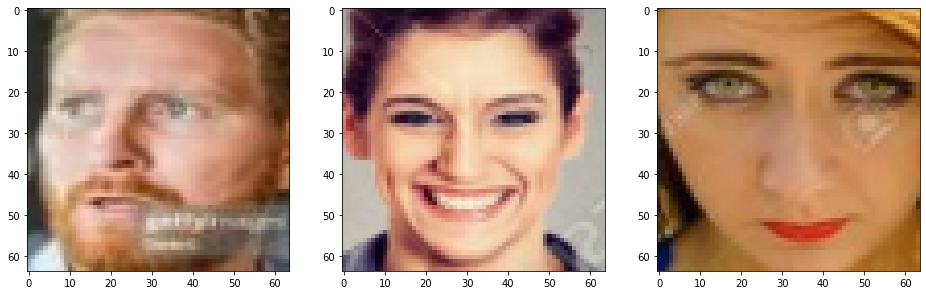

In [7]:
plt.figure(figsize=(16,12))
plt.subplot(1,3,1)
plt.imshow(shock_img[np.random.randint(0,150)])
plt.subplot(1,3,2)
plt.imshow(happy_img[np.random.randint(0,150)])
plt.subplot(1,3,3)
plt.imshow(sad_img[np.random.randint(0,150)])
plt.show()

We are going to create an **X_train** which will contain arrays of the images & a **y_train** to hold the label numbers. There will be some points that need to be paid close attention.

1) Both **X_train** & **y_train** will be sequential! First 180 images will belong to *sad* class, the second 180 is for the *shock* class and the last sequence corresponds to the *happy* people. Thus, while training the model (or even before), one should remember to shuffle the batches to avoid any obstacle on the learning path.

2) **y_train** has only numbers, which are **0**, **1** and **2**. These are the *sad*, *shocked* & *happy* classes, respectively.

3) About 100 images will be put aside for the test set. So there will be less than $3 * 180 = 540$ images in the train set. Numbers may change.

In [8]:
X_train = np.concatenate([sad_img, shock_img, happy_img], axis=0)
y_train = np.array([0]*180 + [1]*180 + [2]*180)
# in case of dimensional error:
# y_train = np.array([0]*180 + [1]*180 + [2]*180, ndmin=2).T

# 100 pictures in total were chosen for the test set
np.random.seed(42)
random_sad = np.random.choice(range(0, 180), 33, replace=False)
random_shock = np.random.choice(range(180, 360), 33, replace=False)
random_happy = np.random.choice(range(360, 540), 34, replace=False)
random_indices = np.concatenate([random_sad,
                                 random_shock,
                                 random_happy])

X_test = X_train[random_indices]
y_test = y_train[random_indices]
# let's remove the selected pictures from the train set
X_train = np.delete(X_train, random_indices, axis=0)
y_train = np.delete(y_train, random_indices, axis=0)

# ...and dispose of these temporary variables:
del random_sad, random_shock, random_happy, random_indices

# Do not forget to shuffle to deck:
def shuffle_set():
    # to make sure the shuffle is the same for both of them,
    random_state = np.random.get_state()
    np.random.shuffle(X_train)
    # we keep the random state and pass it to the next step:
    np.random.set_state(random_state)
    np.random.shuffle(y_train)
shuffle_set()

In [9]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img

In [10]:
# https://keras.io/api/preprocessing/image/#imagedatagenerator-class
train_datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=35,    # adjusted
    width_shift_range=0.20,    # adjusted
    height_shift_range=0.20,    # adjusted
    brightness_range=(0.75, 1.25),    # adjusted
    shear_range=0.20,    # adjusted
    zoom_range=0.20,    # adjusted
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,    # adjusted
    vertical_flip=False,
    rescale=1.0/255,    # adjusted
    preprocessing_function=None,
    data_format=None,
    validation_split=0.2,    # adjusted
    dtype=None,
)

test_datagen = ImageDataGenerator(rescale=1.0/255)

Some example of generated pictures:

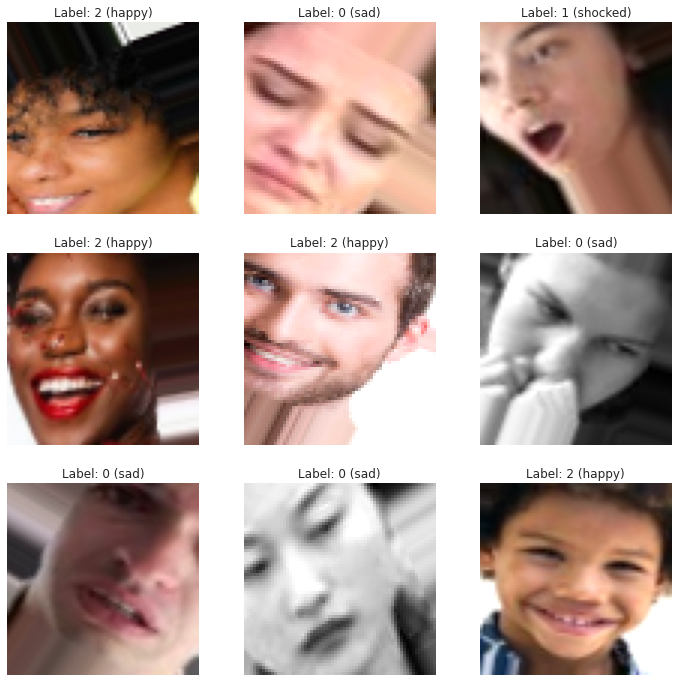

In [11]:
# https://keras.io/api/preprocessing/image/#flow-method
train_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=1, 
                                     shuffle=True,
                                     seed=None, 
                                     subset="training",
                                     )
validation_generator = train_datagen.flow(x=X_train, y=y_train, 
                                     batch_size=1, 
                                     shuffle=True,
                                     seed=None, 
                                     subset="validation",
                                     )
test_generator = test_datagen.flow(x=X_test, y=y_test, 
                                     batch_size=1, 
                                     shuffle=True, 
                                     seed=None,
                                     )
sns.set_style(style="white")
plt.figure(figsize=(12,12))
for i, picture in enumerate(train_generator):
    plt.subplot(3,3,i+1)
    plt.imshow(array_to_img(picture[0][0]))
    label_num = picture[1][0]
    label_str = "happy" if label_num==2 else "shocked" if label_num else "sad" 
    plt.title(f"Label: {label_num} ({label_str})")
    plt.axis("off")
    if i == 8:
        break
plt.show()

# 2. Creating The Model

## 2.1 Shape of The Dataset

In [12]:
from keras import models, layers

In [13]:
print("---Shape of the train set---\nX_train:", X_train.shape, 
      "\ny_train:", y_train.shape)
print("\n---Shape of the test set---\nX_test:", X_test.shape, 
      "\ny_test:", y_test.shape)

---Shape of the train set---
X_train: (440, 64, 64, 3) 
y_train: (440,)

---Shape of the test set---
X_test: (100, 64, 64, 3) 
y_test: (100,)


## 2.2 Neural Network Models

### 2.2.1 A Simple, Baseline Model
We only have a convolutional and a pooling layer in the baseline model.

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.3))
# model.add(layers.BatchNormalization())
# model.add(layers.Conv2D(filters=256, 
#                         kernel_size=(3, 3),
#                         activation="relu"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))
# model.add(layers.Conv2D(filters=16, 
#                         kernel_size=(3, 3),
#                         activation="relu"))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.BatchNormalization())
model.add(layers.Flatten())
# model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30752)             0         
_________________________________________________________________
Output_Layer (Dense)         (None, 3)                 92259     
Total params: 93,155
Trainable params: 93,155
Non-trainable params: 0
_________________________________________________________________


When/If needed, we are going to change the parameters in these functions. <br>Otherwise, they just will be called on demand for our newly created models.

In [16]:
def compile_model():
    model.compile(optimizer="adam", 
                loss="sparse_categorical_crossentropy", 
                metrics=["accuracy"])
    # fit the set
    model_history = model.fit(train_generator, 
                    batch_size=1, 
                    epochs=100, 
                    steps_per_epoch = None,
                    verbose=0, 
                    validation_data=validation_generator
                    )
    return model_history
model_history = compile_model()

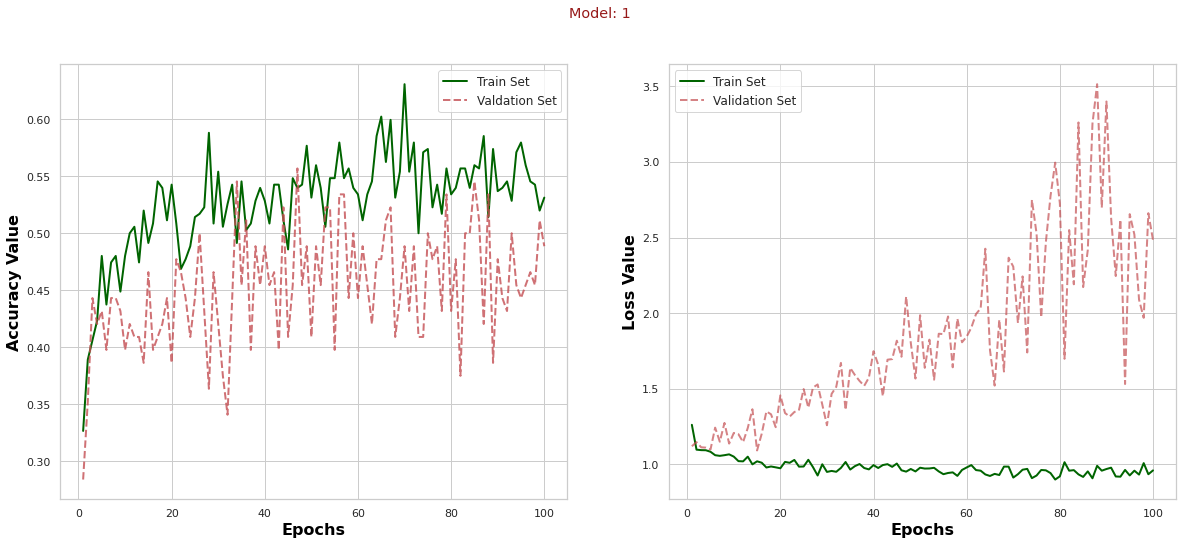

In [21]:
# cosmetic configuration
def display_graph(model_number=None):
    sns.set(style="whitegrid")
    title_font = {"family":"sans", 
                "color":"darkred", 
                "size":30, 
                "weight":"bold", 
                "alpha":0.9}
    axis_font = {"family":"sans-serif", 
                "color":"black", 
                "size":16, 
                "weight":"bold"}

    # plot the graphs
    plt.figure(figsize=(20,8))
    plt.suptitle("Model: " + str(model_number), fontdict=title_font)
    plt.subplot(1,2,1)
    plt.plot(range(1, len(model_history.history["accuracy"])+1), 
            model_history.history["accuracy"], 
            color="darkgreen", linewidth=2, label="Train Set")
    plt.plot(range(1, len(model_history.history["val_accuracy"])+1), 
            model_history.history["val_accuracy"], 
            "r--", linewidth=2, label="Valdation Set", alpha=0.8)
    plt.xlabel("Epochs", fontdict=axis_font)
    plt.ylabel("Accuracy Value", fontdict=axis_font)
    plt.legend(fontsize="medium", loc=0)

    plt.subplot(1,2,2)
    plt.plot(range(1, len(model_history.history["loss"])+1), 
            model_history.history["loss"], 
            color="darkgreen", linewidth=2, label="Train Set")
    plt.plot(range(1, len(model_history.history["val_loss"])+1), 
            model_history.history["val_loss"], 
            "r--", linewidth=2, label="Validation Set", alpha=0.7)
    plt.xlabel("Epochs", fontdict=axis_font)
    plt.ylabel("Loss Value", fontdict=axis_font)
    plt.legend(fontsize="medium", loc=0)

    plt.show()
display_graph(1)

### 2.2.2 Model Number 2
Now we are going to add two Conv2D layer to the model.

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.3))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.BatchNormalization())
model.add(layers.Flatten())
# model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)             

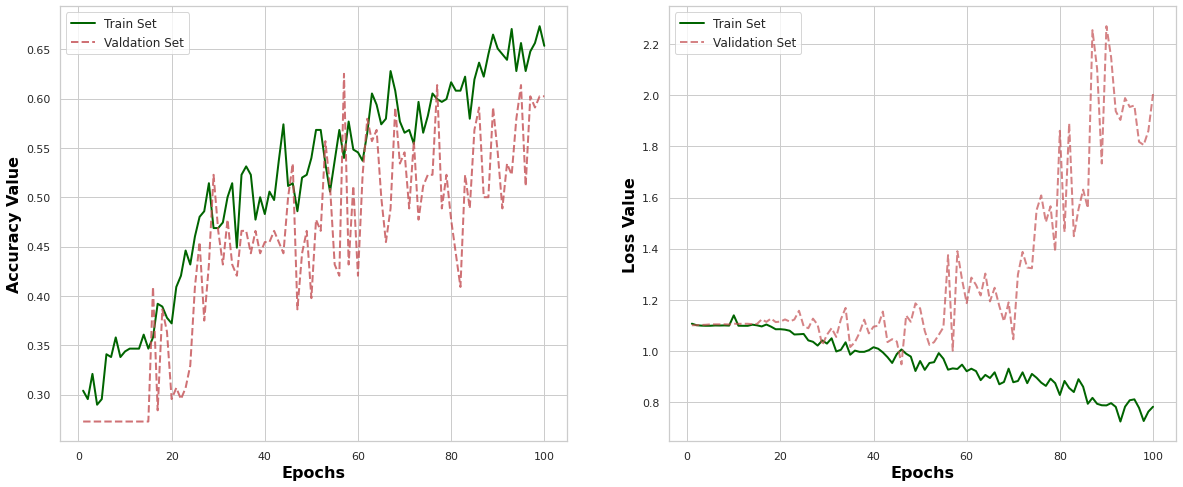

In [16]:
model_history = compile_model()
display_graph(2)

### 2.2.3 Model Number 3
A Dense layer is added just before the output.

In [17]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.3))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1152)             

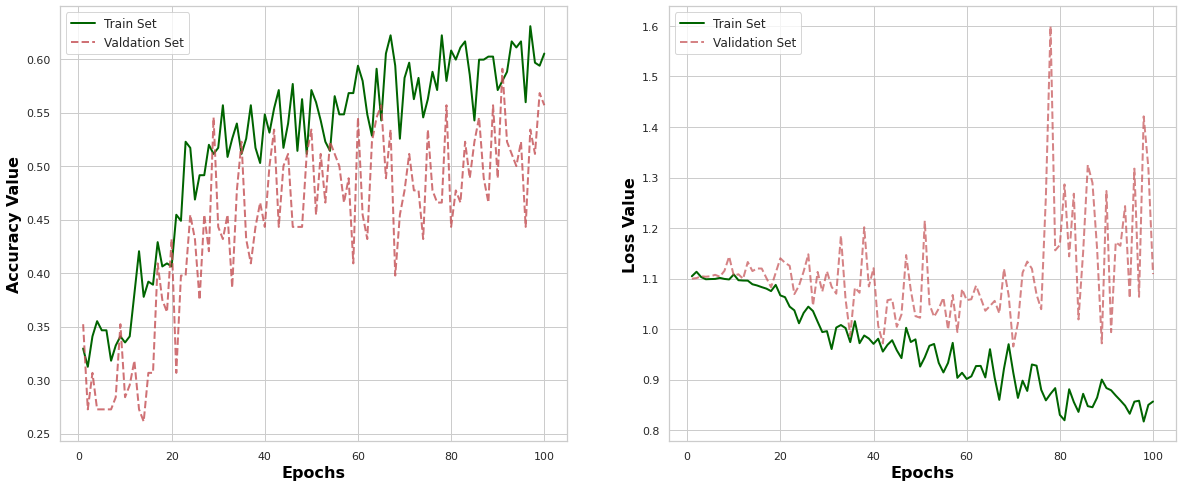

In [18]:
model_history = compile_model()
display_graph(3)

### 2.2.4 Model Number 4
Dropout layers are activated.

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
# model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 12, 12, 32)       

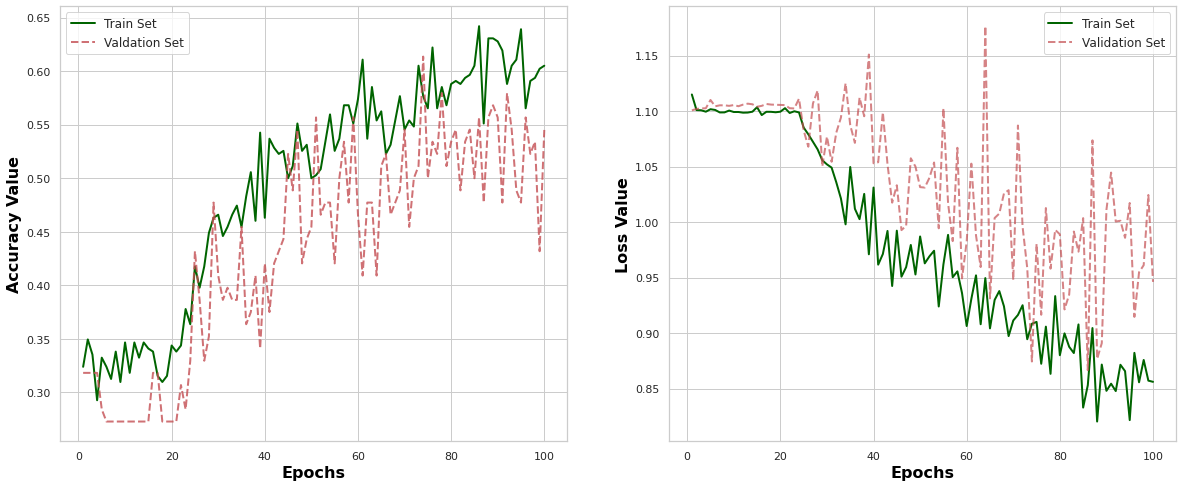

In [20]:
model_history = compile_model()
display_graph(4)

### 2.2.5 Model Number 5
Wow... We failed on dropouts pretty good. Let's get rid of them and add some BatchNormalization. This will be like updating Model 3 since we skip the dropouts.

In [21]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 31, 31, 32)        128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 12, 12, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 6, 6, 32)         

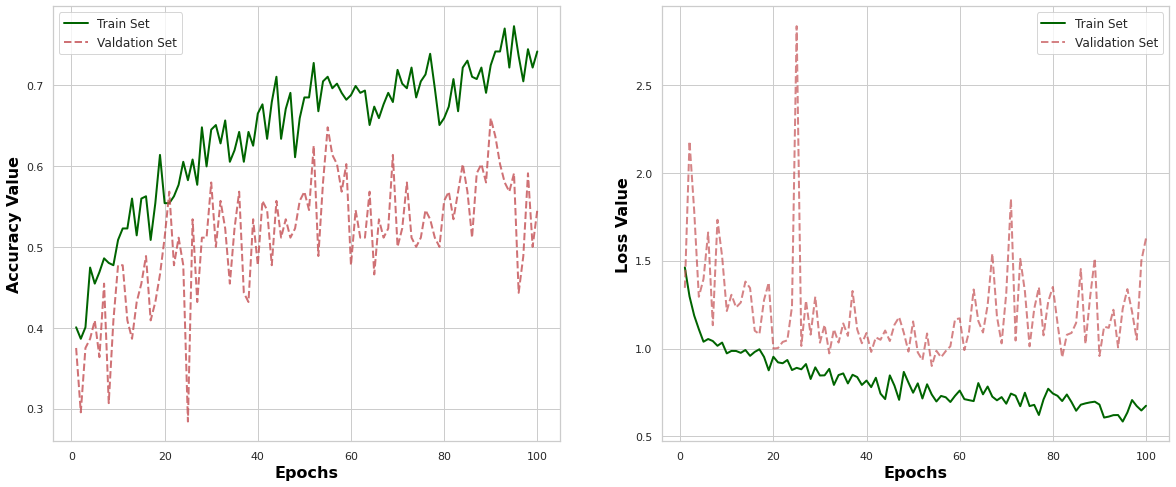

In [22]:
model_history = compile_model()
display_graph(5)

### 2.2.6 Model Number 6
BatchNormalization highly damped the loss value and made the validation accuracy a bit unstable. Even though it seems fine on training data and a little bit more epochs would make it better, it had better we stick to the model 3 and try a few regularization techniques.

#### 2.2.6.1 L1 regularization
Starting with L1 regularization

In [23]:
from keras import regularizers

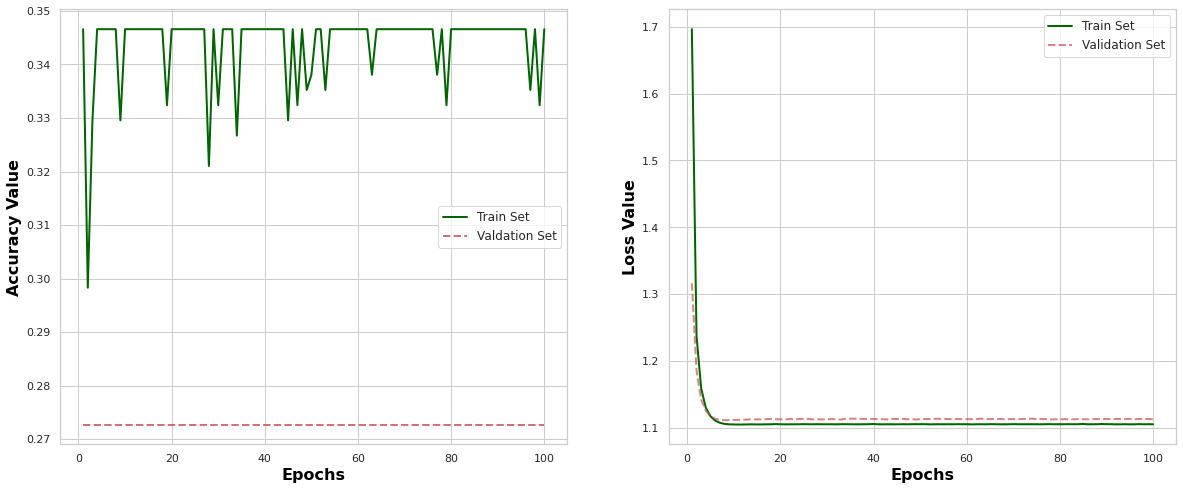

In [24]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=regularizers.l1(0.001), 
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        kernel_regularizer=regularizers.l1(0.001), 
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=regularizers.l1(0.001), 
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu", 
                       kernel_regularizer=regularizers.l1(0.001)))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))

model_history = compile_model()
display_graph(6.1)

#### 2.2.6.2 L2 regularization
How about some L2 regularization?

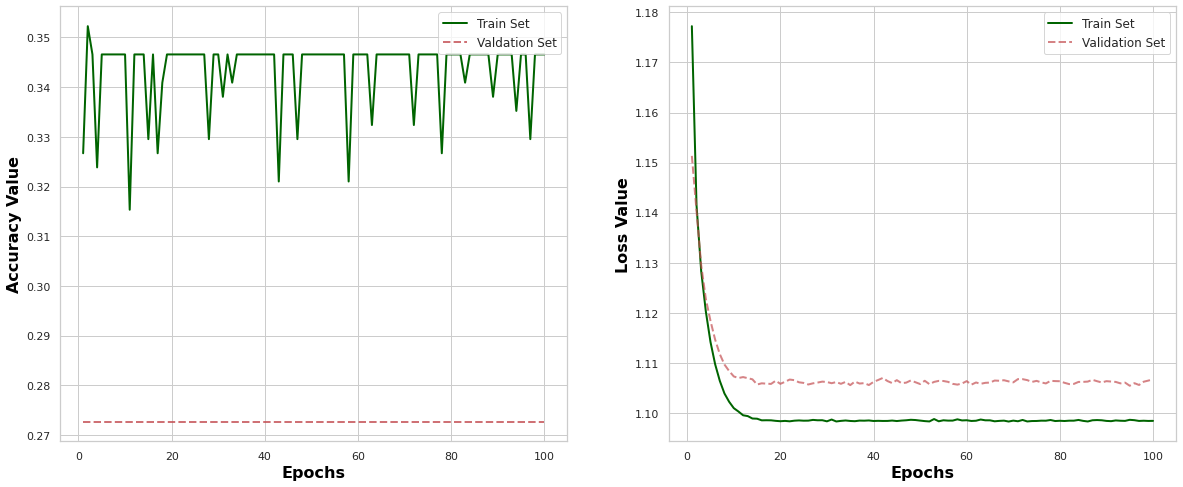

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=regularizers.l2(0.001), 
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3),
                        kernel_regularizer=regularizers.l2(0.001), 
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3, 3), 
                        kernel_regularizer=regularizers.l2(0.001), 
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu", 
                       kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))

model_history = compile_model()
display_graph(6.2)

### 2.2.7 Model Number 7
Alright. Lasso gave us a hard time and Ridge hindered the growth of the accuracy graph too even though the grapgs look more stable.

Now we are going to try to improve Model 3 now by adding/removing hidden layers, neurons and so on. When it's done, the final model will be displayed below.

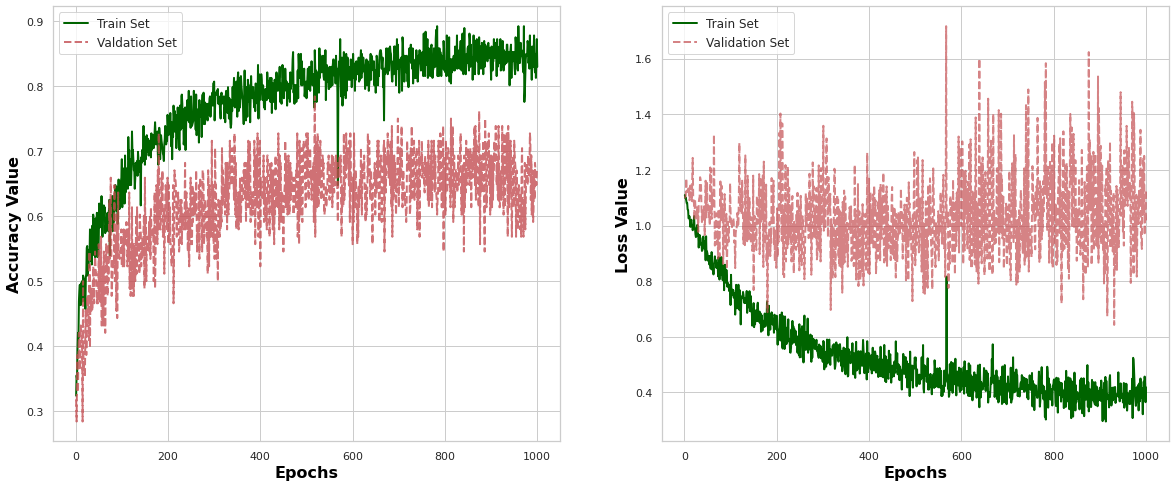

In [26]:
model = models.Sequential()
model.add(layers.Conv2D(filters=8, 
                        kernel_size=(3, 3),
                        activation="relu", 
                        input_shape=X_train.shape[1:]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=8, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(filters=16, 
                        kernel_size=(3, 3),
                        activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(3, activation="softmax", name="Output_Layer"))

model.compile(optimizer="adam", 
            loss="sparse_categorical_crossentropy", 
            metrics=["accuracy"])
# fit the set
model_history = model.fit(train_generator, 
                batch_size=1, 
                epochs=1500, 
                steps_per_epoch = None,
                verbose=0, 
                validation_data=validation_generator
                )

display_graph(7)

In [27]:
model.evaluate(X_test, y_test, batch_size=1)

100/100 [==============================] - 0s 2ms/step - loss: 138.4265 - accuracy: 0.7400


[138.42649841308594, 0.7400000095367432]